#  Collaborative Based Recommendations

<span>Collaborative Recommendations Systems work under the assumptions that user tastes are similar to each other. Therefore our target user would prefer a recommendation from a group of our peers. This notebook will working python code for different approaches to building collaborative recommendation systems.  </span>

### Import Preliminaries

In [1]:
# Import generic data science packages
%matplotlib inline
%config InlineBackend.figure_format='retina'


# Import modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd 
import sklearn
import seaborn as sns
import warnings

# Import Model Selection
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

# Ignore Warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
# Import dataframe
columns = ['user', 'movie', 'score', 'timestamp']
df = pd.read_csv('/Users/kavi/Documents/Science/Brainstation/Python Labs/Recommendation Systems/u.data', sep='\t', names=columns)
print(df.shape)
df.head()

(100000, 4)


user  movie  score  timestamp
0   196    242      3  881250949
1   186    302      3  891717742
2    22    377      1  878887116
3   244     51      2  880606923
4   166    346      1  886397596

### Data Overview

In [11]:
# Total nulmber of users and Movies
print('Total Number of User', df.user.max())
print('Total Number of Movies', df.movie.max())

Total Number of User 943
Total Number of Movies 1682


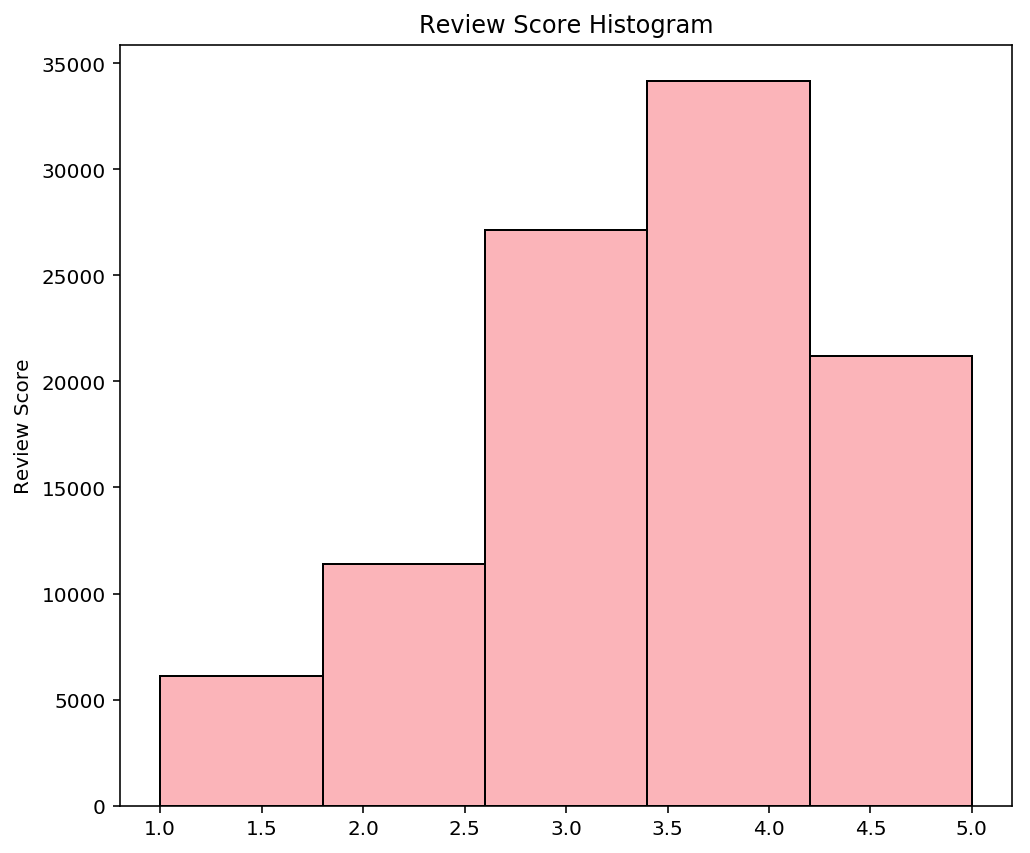

In [13]:
# Revie Score Histogram
df.score.plot.hist(color='#fbb4b9', edgecolor='black',
              bins =5)
plt.title('Review Score Histogram')
plt.ylabel('Review Score');

In [14]:
print(f'User {df.user.unique()[15]} has watched the following movies:\n \
{np.unique(df[df.user == df.user.unique()[15]].movie)}')

User 303 has watched the following movies:
 [   1    2    3    4    5    7    8    9   11   12   13   15   17   21   22
   23   24   25   26   28   29   31   33   38   41   42   43   44   46   47
   49   50   53   54   55   56   62   63   64   65   67   68   69   70   71
   72   73   77   78   79   80   81   82   83   85   87   88   90   91   92
   93   94   95   96   97   98   99  100  106  109  111  116  117  118  120
  121  122  123  124  125  127  128  129  132  134  137  139  141  143  144
  145  147  150  151  152  153  155  156  158  159  160  161  164  167  168
  170  171  172  173  174  176  179  181  182  183  184  185  186  187  191
  194  195  198  200  201  202  203  204  208  209  210  215  216  218  219
  221  222  223  226  227  228  229  230  231  232  233  234  235  236  237
  238  239  240  241  245  246  248  249  250  251  252  255  257  258  259
  260  262  264  268  269  270  271  273  276  277  281  282  283  284  286
  287  288  289  290  291  293  294  298  30

## Recommendation System 1: User-Item Filtering

In [15]:
# Creaet a list of unique users and movies
users = df['user'].unique()
movies = df['movie'].unique()

# Store the lenght of these unique lists 
num_users = len(users)
num_movies = len(movies)

# Np.full() Returns a new array of given shape and type, 
# filled with fill_value, -1 means they user has not reviewed
reviews = np.full((num_users,num_movies),-1)
reviews

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [16]:
# Build the user-item matrix by iterating ove the reviews matrix, 
# filling in the review score for each item and user combinations
# where a review for the item exists
for row in df.itertuples() :
    user = row[1]
    movie = row[2]
    rating = row[3]
    reviews [user-1,movie-1] = rating
    
# View the updated xreviews matrix
reviews

array([[ 5,  3,  4, ..., -1, -1, -1],
       [ 4, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [ 5, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1,  5, -1, ..., -1, -1, -1]])

In [17]:
# View reivew dataframe as a DataFrame for the first 16 users
# Columns are items, each row is a user, -1 are missing reviews
# We will generate recommendation from the misssing reviews

reviews_df = pd.DataFrame(reviews)
reviews_df[:16]

0     1     2     3     4     5     6     7     8     9     10    11    \
0      5     3     4     3     3     5     4     1     5     3     2     5   
1      4    -1    -1    -1    -1    -1    -1    -1    -1     2    -1    -1   
2     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
3     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1     4    -1   
4      4     3    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
5      4    -1    -1    -1    -1    -1     2     4     4    -1    -1     4   
6     -1    -1    -1     5    -1    -1     5     5     5     4     3     5   
7     -1    -1    -1    -1    -1    -1     3    -1    -1    -1     3    -1   
8     -1    -1    -1    -1    -1     5     4    -1    -1    -1    -1    -1   
9      4    -1    -1     4    -1    -1     4    -1     4    -1     4     5   
10    -1    -1    -1    -1    -1    -1    -1     4     5    -1     2     2   
11    -1    -1    -1     5    -1    -1    -1    -1    -1    -1    -1    -1   
12     3     3    -1     5     1    -1     2     4     3    -1     1     5   
13    -1    -1    -1    -1    -1    -1     5    -1     4    -1    -1     5   
14     1    -1    -1    -1    -1    -1     1    -1     4    -1    -1    -1   
15     5    -1    -1     5    -1    -1     5     5     5    -1     5     5   

    12    13    14    15    16    17    18    19    20    21    22    23    \
0      5     5     5     5     3     4     5     4     1     4     4     3   
1      4     4    -1    -1    -1    -1     3    -1    -1    -1    -1    -1   
2     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
3     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
4     -1    -1    -1    -1     4    -1    -1    -1     3    -1    -1     4   
5      2     5     3    -1    -1    -1     4    -1     3     3     4    -1   
6     -1    -1    -1    -1    -1    -1    -1    -1    -1     5     3    -1   
7     -1    -1    -1    -1    -1    -1    -1    -1    -1     5    -1    -1   
8     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
9      3    -1    -1     4    -1    -1    -1    -1    -1     5     5    -1   
10    -1    -1     5    -1    -1    -1    -1    -1    -1     4    -1     3   
11    -1    -1     5    -1    -1    -1    -1    -1    -1    -1    -1    -1   
12     5     4    -1    -1     1    -1    -1    -1     3     4     5     1   
13     4     3     4    -1    -1     3     5    -1    -1     3     5    -1   
14     1     4     4    -1    -1     1    -1     3    -1    -1    -1    -1   
15    -1    -1     5    -1    -1    -1    -1    -1    -1     5    -1    -1   

    24    25    26    27    28    29    30    31    32    33    34    35    \
0      4     3     2     4     1     3     3     5     4     2     1     2   
1      4    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
2     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
3     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
4      3    -1    -1    -1     4    -1    -1    -1    -1    -1    -1    -1   
5     -1    -1    -1     2    -1    -1    -1     4    -1    -1    -1    -1   
6      3    -1     4     5     3    -1     4     4    -1    -1    -1    -1   
7     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
8     -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
9     -1    -1    -1    -1    -1    -1    -1     4     4    -1    -1    -1   
10     3    -1    -1     5     3    -1    -1    -1    -1    -1    -1    -1   
11    -1    -1    -1     5    -1    -1    -1    -1    -1    -1    -1    -1   
12     1    -1     3     5     2    -1    -1     4     5    -1    -1    -1   
13     2    -1    -1    -1    -1    -1    -1     5    -1    -1    -1    -1   
14     3    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
15    -1    -1     2     5    -1    -1     5    -1     2    -1    -1    -1   

    36    37    38    3

### Retrieving a Single Item Recommendation

In this problem, we have 943 users, and 1682 items in our system. We will build a recommendation system that predicts the best recommendations for 1486126 missing review. This process will involve at least 2499663932 calculations. Retrieving the recommendations for this target user given an item in our data will take this script about 301 milliseconds. The function is defined below.

In [18]:
def user_item_recommendation(target_user=15, item=1, reviews=reviews) -> float:
    '''
    Given a user index value and item index value. Our Recommondation System susing 
    Collaborative User-item Filtering will provide us with our predicted review
    given this user and item
    
    Paramters
    ---------
    User: user's index value
    Item: item's index value
    
    '''
    target_user_sim = []
    user_x_item_1_sim = []
    counter = 0 #remove 

    for user in users:

        # P2 review of the item 
        p2_intial_review = reviews[user-1,item]


        # Did the user review this item if not move on
        if p2_intial_review == -1:
            continue

        p1_review_mask  = (reviews[target_user,:] != -1) # This will be a list of booleans
        p2_review_mask = (reviews[user-1,:] != -1) # This will be a list of booleans

        # A boolean and list of all the items the both users have reviewed
        mask = (p1_review_mask & p2_review_mask)

        #If they have No overlap don't use them 
        if True not in mask :
            continue

        # A list of reviewed items of each 
        p1_reviews = reviews[target_user,mask].reshape(1,-1)
        p2_reviews = reviews[user-1,mask].reshape(1,-1)

        # Calculate the similarity score
        similarity_score = cosine_similarity(p1_reviews ,p2_reviews )

        # Append the user score similarity score
        target_user_sim.append(similarity_score)

        # Append the users review for item one
        user_x_item_1_sim.append(reviews[user-1,1])

    # Convert our lists into numpy arrays.
    target_user_sim  = np.array(target_user_sim).reshape(1,-1)
    user_x_item_1_sim = np.array(user_x_item_1_sim)

    # Calculated our predicted review for this movie
    pred_review = (1 / len(user_x_item_1_sim)) * np.dot(target_user_sim, user_x_item_1_sim)
    return pred_review[0]

print('User 15, Item 1 = Similarity Metric:', user_item_recommendation(target_user=15, item=1))

User 15, Item 1 = Similarity Metric: 3.08290576533


### Retrieve User Recommendations

Great, we have returned the recommendation based on given item. Next, we iterate over every movie that our target user has not reviewed and returned the peer review score(based on similarity). After retrieving the scoring for each film, we will return a sorted list of recommended items based on the peer review scored.


In [21]:
def get_user_item_recommedations(target_user: int, item_range = range(0,1682), reviews=reviews) -> pd.DataFrame:
    '''
    Base on user id retrieve all the movie recommendations that the user is most likely to enjoy based on
    potential review score of other users with similar interest. 

    Parameters
    ----------
    target_userget_user: Index value of the target user
    items: range of items so search for in the item search space. By default we are searching all 
    the items
    

    '''
    assert (max(list(item_range)) >= len(reviews)), '''item_range is above the length of items in your range,
                                                       reduce search space'''

    user_recommendations= []
    movie_names = []

    for item in item_range:

        # check if our target user has reviewd this item
        p1_intial_review = reviews[target_user,item]

        # Did the target user reviewed this item then move on
        if p1_intial_review != -1:
            continue

        # Retrieve similarity score for non review movied 
        user_recommendations.append(user_item_recommendation(target_user=target_user, item=item))

        # Append movie name to a list
        movie_names.append(df.movie[item])

    # Wranle the Movie together
    movie_names = pd.Series(movie_names, name='movie')
    user_recommendations = pd.Series(user_recommendations, name='similar_users_average_review')
    user_recommendations = pd.concat([movie_names, user_recommendations], axis=1)
    user_recommendations = user_recommendations.sort_values(by='similar_users_average_review',ascending=False)
    
    return pd.DataFrame(user_recommendations).head()


# Test our function for user 15
get_user_item_recommedations(target_user=15)

movie  similar_users_average_review
1453    273                         4.392
1048    948                         4.226
1341     82                         3.915
1462     83                         3.880
1520    243                         3.822

In [22]:
# Test our function for user 27
get_user_item_recommedations(target_user=27)

movie  similar_users_average_review
1514    273                         4.392
1109    948                         4.231
1402     82                         3.894
1523     83                         3.830
1581    243                         3.815

In [23]:
# Test our fucntion for user 74
get_user_item_recommedations(target_user=74)

movie  similar_users_average_review
1514    273                         4.195
1109    948                         4.085
1581    243                         3.833
1402     82                         3.808
1577    685                         3.734

Perfect. We have our recommendations for this user.

### General Notes

- User-Item Recommendation Systems are computationally expensive
- Amazon uses an Item-Item Recommendation System.

### Source

- [Collaborative Filtering Wiki Page](https://en.wikipedia.org/wiki/Collaborative_filtering)

Author: Kavi Sekhon

### General Note